### Benson Challenges


### Optional (if I want to write to a TXT file first and write out a CSV file)

In [21]:
# #PREP - READING IN TXT FILE AND MAKING A SHORT VERSION TO WORK WITH

#-----------------------------------------

# import csv
# import dateutil.parser
# import matplotlib.pyplot as plt
# import numpy as np
# import datetime
# import calendar
# import copy
# from collections import defaultdict, Counter
# from pprint import pprint
# from itertools import groupby

# #initially downloading the Turnstile Data to a txt file
# def writethefile(url):
#     with open ("Turnstile.txt", "w") as f:
#         read_url = urlopen(URL).read()
#         f.write(read_url)  


# #making a shorter sample file for testing purposes
# def makeshortfile():
#     with open("Turnstile.txt", "r") as f, open("TurnstileShort.txt", "w") as out:
#         r = csv.reader(f)
#         count = 0
#         for row in f:
#             out.write(row)
#             count += 1
#             if count > 2000:
#                 break

# URL = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_150627.txt'
# writethefile(URL)

# mydict = defaultdict(list)

# with open("Turnstile.txt", "r") as f, open("TurnstileSorted.csv", "w") as out:
#     r = csv.reader(f)
#     throwawayline = next(r)
#     for row in r:
#         CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS = row
#         mydict[(CA, UNIT, SCP, STATION)].append([LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS])
        
#     wr = csv.writer(out, delimiter = '\t')
#     wr.writerows([(k,v) for k,v in mydict.items()])
     
#print 'Done here.'



### Challenge 1

- Open up a new IPython notebook
- Download a few MTA turnstile data files
- Open up a file, use csv reader to read it, make a python dict where
  there is a key for each (C/A, UNIT, SCP, STATION). These are the
  first four columns. The value for this key should be a list of
  lists. Each list in the list is the rest of the columns in a
  row. For example, one key-value pair should look like


{    ('A002','R051','02-00-00','LEXINGTON AVE'):
[
['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'],
['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'],
['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'],
...
]
}


In [2]:
#CHALLENGE 1

import csv
import dateutil.parser
import matplotlib.pyplot as plt
import numpy as np
import datetime
import calendar
import copy
from collections import defaultdict, Counter
from pprint import pprint
from itertools import groupby

def separate_into_dict(filename):
    some_dict = defaultdict(list)
    with open(filename, "r") as f:
        r = csv.reader(f)
        throwawayline = next(r)
        for row in r:
            CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS = row
            some_dict[(CA, UNIT, SCP, STATION, LINENAME)].append([DIVISION,DATE,TIME,DESC,ENTRIES,EXITS])
    print "Made a dictionary with", filename + "."
    return dict(some_dict)

def shorten_dict(dictionaryname):
    return {k : map(lambda x: [x[1], x[2], x[4]], v) for k, v in dictionaryname.items()}
    
some_dict = shorten_dict(separate_into_dict('datafiles/turnstile_150627.txt'))

#pprint(some_dict)
print 'Done here.'

Made a dictionary with datafiles/turnstile_150627.txt.
Done here.


### Challenge 2

- Let's turn this into a time series.

 For each key (basically the control area, unit, device address and
 station of a specific turnstile), have a list again, but let the list
 be comprised of just the point in time and the count of entries.

This basically means keeping only the date, time, and entries fields
in each list. You can convert the date and time into datetime objects
-- That is a python class that represents a point in time. You can
combine the date and time fields into a string and use the
[dateutil](https://labix.org/python-dateutil) module to convert it
into a datetime object. For an example check
[this StackOverflow question](http://stackoverflow.com/questions/23385003/attributeerror-when-using-import-dateutil-and-dateutil-parser-parse-but-no).

Your new dict should look something like

{    ('A002','R051','02-00-00','LEXINGTON AVE'):
[
[datetime.datetime(2013, 3, 2, 3, 0), 3788],
[datetime.datetime(2013, 3, 2, 7, 0), 2585],
[datetime.datetime(2013, 3, 2, 12, 0), 10653],
[datetime.datetime(2013, 3, 2, 17, 0), 11016],
[datetime.datetime(2013, 3, 2, 23, 0), 10666],
[datetime.datetime(2013, 3, 3, 3, 0), 10814],
[datetime.datetime(2013, 3, 3, 7, 0), 10229],
...
],
....
}


In [3]:
#CHALLENGE 2

def dateconverter(a,b):
    newstring = " ".join((a,b))
    return dateutil.parser.parse(newstring)

dateconverted_dict = {k : map(lambda x: [dateconverter(x[0], x[1]), x[2]], v) for k, v in some_dict.items()}

#pprint(dateconverted_dict)
print 'Done here.'

Done here.


In [4]:
def get_deltas(dictionaryname):
    testdict = defaultdict(list)
    for key1 in dictionaryname:  
        numb_entries_for_wk = len(dictionaryname[key1])
        for i, rowvalues in enumerate(dictionaryname[key1]):
            #print i, rowvalues
            if i == 0:
                odometer = int(rowvalues[1])
                testdict[key1].append([rowvalues[0], 0])

            elif 0 < i < numb_entries_for_wk:
                diff = int(rowvalues[1]) - odometer
                odometer = int(rowvalues[1])
                testdict[key1].append([rowvalues[0], diff])
    return dict(testdict)

testdict = get_deltas(dateconverted_dict)
#pprint(testdict)
print 'Done here.'

Done here.


### Challenge 3

- These counts are for every n hours. (What is n?) We want total daily
  entries.

Now make it that we again have the same keys, but now we have a single
value for a single day, which is the total number of passengers that
entered through this turnstile on this day.

In [5]:
def rid_outliers(dictionaryname):
    outlier_dict = {turnstile: [(time, count)
                            for (time, count) in rows
                            if 0 <= count <= 5000] for turnstile, rows in dictionaryname.items()}
    return outlier_dict

outlier_dict = rid_outliers(testdict)

"""---- outlier_dict has all the outliers dropped. ----"""

def drop_date_details(dictionaryname):
    interimdict = defaultdict(list)
    for key in dictionaryname:
        for rowvalues in dictionaryname[key]:
            newdates = rowvalues[0].replace(hour=0, minute=0, second=0)
            interimdict[key].append([newdates, rowvalues[1]])
    return dict(interimdict)

interimdict = drop_date_details(outlier_dict)
#pprint(interimdict)

"""---- interimdict has dates all uniformed with hours.mins.secs dropped. ----"""


def groupby_date(dictionaryname):
    dict_by_days = defaultdict(list)
    for fatkey in dictionaryname:
        eachvalblock = dictionaryname[fatkey]
        x = groupby(eachvalblock, lambda x1:x1[0])
        newt = []
        for y, z in x:
            ex_list = []
            for a in z:
                ex_list.append(a[1])
            newt.append([y,sum(ex_list)])
        dict_by_days[fatkey] = newt
    return dict(dict_by_days)

dict_by_days = groupby_date(interimdict)
#pprint(dict_by_days)
print 'Done here.'

Done here.


### Challenge 4

We will plot the daily time series for a turnstile.

In ipython notebook, add this to the beginning of your next cell:

    %matplotlib inline

This will make your matplotlib graphs integrate nicely with the
notebook. To plot the time series, import matplotlib with

    import matplotlib.pyplot as plt

Take the list of [(date1, count1), (date2, count2), ...], for the
turnstile and turn it into two lists:
dates and counts. This should plot it:

    plt.figure(figsize=(10,3))
    plt.plot(dates,counts)

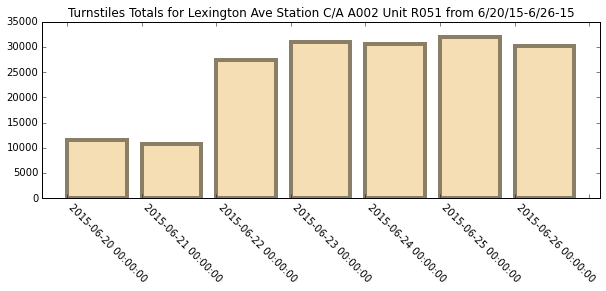

In [6]:
#CHALLENGE 4 - made a slight modification as I wanted a more custom chart.

%matplotlib inline

def make_days_of_wk_barchart(dictionaryname, stationname, charttitle):
    firstday = secondday = thirdday = fourthday = fifthday = sixthday = seventhday = 0

    date_list = [i[0] for i in dictionaryname.values()[0]]

    for key in dictionaryname:
        if key[3] == stationname:
            for n in range(7):
                try:  
                    numbers = dictionaryname[key][n][1]
                    if n == 0:
                        firstday += numbers
                    elif n == 1:
                        secondday += numbers
                    elif n == 2:
                        thirdday += numbers
                    elif n == 3:
                        fourthday += numbers
                    elif n == 4:
                        fifthday += numbers
                    elif n == 5:
                        sixthday += numbers
                    elif n == 6:
                        seventhday += numbers
                except:
                    pass

    count_list = [firstday, secondday, thirdday, fourthday, fifthday, sixthday, seventhday]
    # print count_list
    # print(date_list)

    #fig, ax = plt.subplots(figsize=(10,3.5))
    fig=plt.figure(figsize=(10,3.5))
    ax=fig.add_subplot(111)
    width = 0.8
    tickLocations = np.arange(6)
    ax.set_title(charttitle)
    ax.bar(date_list, count_list, width, color='wheat', edgecolor='#8B7E66', linewidth=4.0)
    fig.autofmt_xdate(ha = 'left') #---- WHY IS THIS PRINTING AN EXTRA DAY ON THE X-AXIS
    ax.set_xticklabels(date_list, rotation = 315, horizontalalignment = 'left')
    ax.margins(x=0.05)

make_days_of_wk_barchart(dict_by_days, "LEXINGTON AVE", 
                         "Turnstiles Totals for Lexington Ave Station C/A A002 Unit R051 from 6/20/15-6/26-15")


### Challenge 5

- So far we've been operating on a single turnstile level, let's
  combine turnstiles in the same ControlArea/Unit/Station combo. There
  are some ControlArea/Unit/Station groups that have a single
  turnstile, but most have multiple turnstilea-- same value for the
  C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each
ControlArea/UNIT/STATION combo, for each day, add the counts from each
turnstile belonging to that combo.

In [7]:
#CHALLENGE 5


def groupby_keys(dictionaryname):
    """This currently pulls 4 predetermined keys inside the function, but figure out
    a way to do it using *args."""
    short_data = defaultdict(Counter)

    for key, value in dictionaryname.items():
        short_key = (key[0], key[1], key[3], key[4])
        short_data[short_key] += Counter(dict(dictionaryname[key]))
    #--- values are Counter objects at this point

    short_data = dict(short_data)
    for key, value in short_data.items():
        short_data[key] = list(list(x) for x in value.items())
    for i in short_data:
        short_data[i].sort()
    return short_data

short_data = groupby_keys(dict_by_days)

#pprint(short_data)
print 'Done here.'

Done here.


### Challenge 6

Similarly, combine everything in each station, and come up with a time
series of `[(date1, count1),(date2,count2),...]` type of time series
for each STATION, by adding up all the turnstiles in a station.

In [8]:
#CHALLENGE 6

def groupby_loc(dictionaryname):

    station_dict = defaultdict(Counter)

    for key, value in dictionaryname.items():
        station_key = (key[2], key[3])
        station_dict[station_key] += Counter(dict(dictionaryname[key]))

    station_dict = dict(station_dict)
    for key, value in station_dict.items():
        station_dict[key] = list(list(x) for x in value.items())
    for i in station_dict:
        station_dict[i].sort()
    return station_dict

station_dict = groupby_loc(short_data)
        
#pprint(station_dict)
print 'Done here.'  

Done here.


### Aside:

Creating a dictionary with station week totals and writing it out to a CSV file.


In [9]:
""" Lets first start by creating a dict that just has station and its week totals. 
    i.e. 'LEXINGTON AVE': 155181"""
def station_totaler(dictionaryname, station):
    total = 0 
    for i in (dictionaryname[station]):
        total += i[1]
    return total

station_tot_dict = {}
for key in station_dict:
    station_tot_dict[key] = station_totaler(station_dict, key)

#pprint(station_tot_dict)
    
station_tot_dict_sorted = sorted(station_tot_dict.items(), key = lambda x :x[1], reverse = True)
#pprint(station_tot_dict_sorted)

print 'Done here.'

Done here.


In [10]:
with open("Station_Totals.csv", "w") as out:
    writer = csv.writer(out, delimiter = ',')
    writer.writerows([(k,v) for k,v in station_tot_dict.items()])
    print 'Done here.'

Done here.


### Challenge 7

Plot the time series for a station.

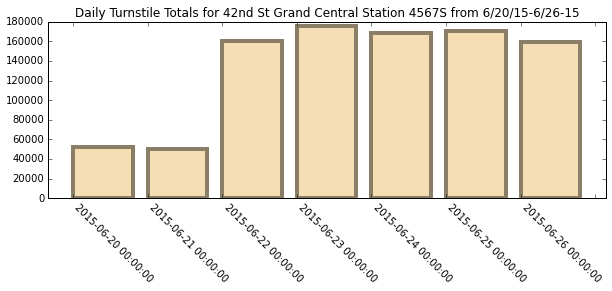

In [11]:
#CHALLENGE 4 - made a slight modification as I wanted a more custom chart.
%matplotlib inline

firstday = secondday = thirdday = fourthday = fifthday = sixthday = seventhday = 0

date_list = [i[0] for i in station_dict.values()[0]]

for key in station_dict:
    if key == ('42 ST-GRD CNTRL', '4567S'):
        for n in range(7):
            try:  
                numbers = station_dict[key][n][1]
                if n == 0:
                    firstday += numbers
                elif n == 1:
                    secondday += numbers
                elif n == 2:
                    thirdday += numbers
                elif n == 3:
                    fourthday += numbers
                elif n == 4:
                    fifthday += numbers
                elif n == 5:
                    sixthday += numbers
                elif n == 6:
                    seventhday += numbers
            except:
                pass

count_list = [firstday, secondday, thirdday, fourthday, fifthday, sixthday, seventhday]

fig=plt.figure(figsize=(10,3.5))
ax=fig.add_subplot(111)
width = 0.8
tickLocations = np.arange(6)
ax.set_title("Daily Turnstile Totals for 42nd St Grand Central Station 4567S from 6/20/15-6/26-15")
ax.bar(date_list, count_list, width, color='wheat', edgecolor='#8B7E66', linewidth=4.0)
fig.autofmt_xdate(ha = 'left') #---- WHY IS THIS PRINTING AN EXTRA DAY ON THE X-AXIS
ax.set_xticklabels(date_list, rotation = 315, horizontalalignment = 'left')
ax.margins(x=0.05)

### Challenge 8

- Make one list of counts for **one** week for one station. Monday's
count, Tuesday's count, etc. so it's a list of 7 counts.
Make the same list for another week, and another week, and another
week.
`plt.plot(week_count_list)` for every `week_count_list` you created
this way. You should get a rainbow plot of weekly commute numbers on
top of each other.

In [12]:
#adding an extra column converting datetime to days of wk in english

def datetime_english(dictionary_name):
    for key in dictionary_name:
        for each_day in dictionary_name[key]:
            if len(each_day) == 2:
                date_in_english = calendar.day_name[each_day[0].weekday()]
                each_day.append(date_in_english)
    return dictionary_name

station_eng_dict = datetime_english(station_dict)
#pprint(station_eng_dict)
print 'Done here.'

Done here.


In [13]:
files = ['datafiles/turnstile_150606.txt', 'datafiles/turnstile_150613.txt', 'datafiles/turnstile_150620.txt']
for i,filename in enumerate(files):
    globals()['some_dict%s' % i] = shorten_dict(separate_into_dict(filename))

"""
some_dict is the original dictionary from 6/20-6/26
some_dict0 is the dict from 5/30-6/5
some_dict1 is the dict from 6/6-6/12
some_dict2 is the dict from 6/13-6/19"""

dateconverted_dict0 = {k : map(lambda x: [dateconverter(x[0], x[1]), x[2]], v) for k, v in some_dict0.items()}
dateconverted_dict1 = {k : map(lambda x: [dateconverter(x[0], x[1]), x[2]], v) for k, v in some_dict1.items()}
dateconverted_dict2 = {k : map(lambda x: [dateconverter(x[0], x[1]), x[2]], v) for k, v in some_dict2.items()}

testdict0 = get_deltas(dateconverted_dict0)
testdict1 = get_deltas(dateconverted_dict1)
testdict2 = get_deltas(dateconverted_dict2)

outlier_dict0 = rid_outliers(testdict0)
outlier_dict1 = rid_outliers(testdict1)
outlier_dict2 = rid_outliers(testdict2)

interimdict0 = drop_date_details(outlier_dict0)
interimdict1 = drop_date_details(outlier_dict1)
interimdict2 = drop_date_details(outlier_dict2)

dict_by_days0 = groupby_date(interimdict0)
dict_by_days1 = groupby_date(interimdict1)
dict_by_days2 = groupby_date(interimdict2)

short_data0 = groupby_keys(dict_by_days0)
short_data1 = groupby_keys(dict_by_days1)
short_data2 = groupby_keys(dict_by_days2)

station_dict0 = groupby_loc(short_data0)
station_dict1 = groupby_loc(short_data1)
station_dict2 = groupby_loc(short_data2)

station_eng_dict0 = datetime_english(station_dict0)
station_eng_dict1 = datetime_english(station_dict1)
station_eng_dict2 = datetime_english(station_dict2)

print 'Done here.'

Made a dictionary with datafiles/turnstile_150606.txt.
Made a dictionary with datafiles/turnstile_150613.txt.
Made a dictionary with datafiles/turnstile_150620.txt.
Done here.


In [14]:
finaldict = copy.deepcopy(station_eng_dict)

for key in station_eng_dict:
    for n in range(7):
        try:
            if station_eng_dict[key][n][2] == station_eng_dict0[key][n][2]:
                finaldict[key][n].append(station_eng_dict0[key][n][1])
            if station_eng_dict[key][n][2] == station_eng_dict1[key][n][2]:
                finaldict[key][n].append(station_eng_dict1[key][n][1])
            if station_eng_dict[key][n][2] == station_eng_dict2[key][n][2]:
                finaldict[key][n].append(station_eng_dict2[key][n][1])
        except:
              pass
                
#pprint(finaldict)
                

{('1 AVE', 'L'): [[datetime.datetime(2015, 6, 20, 0, 0),
                   14703,
                   'Saturday',
                   15519,
                   15759,
                   16004],
                  [datetime.datetime(2015, 6, 21, 0, 0),
                   15627,
                   'Sunday',
                   16429,
                   17286,
                   17548],
                  [datetime.datetime(2015, 6, 22, 0, 0),
                   21936,
                   'Monday',
                   22430,
                   23292,
                   22740],
                  [datetime.datetime(2015, 6, 23, 0, 0),
                   23640,
                   'Tuesday',
                   24570,
                   25068,
                   23901],
                  [datetime.datetime(2015, 6, 24, 0, 0),
                   23868,
                   'Wednesday',
                   25360,
                   25689,
                   25627],
                  [datetime.datetime(20

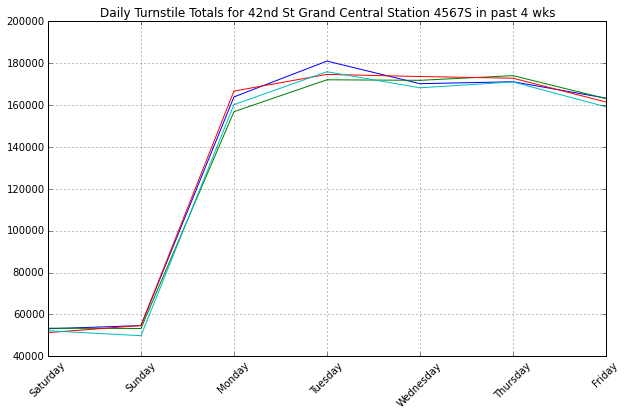

In [27]:
%matplotlib inline

def daysofwk_linechart_by_station(listofdicts, stationname, charttitle):
    
    colors = "bgrcmykw"
    color_index = 0
    
    fig=plt.figure(figsize=(10,6))
    ax=fig.add_subplot(111)
    ticknumbs = np.arange(7)
    ax.set_title(charttitle)
    date_list = [i[2] for i in listofdicts[0].values()[0]]
    ax.set_xticklabels(date_list, rotation = 45)
    #ax.margins(x=0.05, y=0.05)
    
    for eachdict in listofdicts:
        firstday = secondday = thirdday = fourthday = fifthday = sixthday = seventhday = 0

        for key in eachdict:
            if key == stationname:
                for n in range(7):
                    try:  
                        numbers = eachdict[key][n][1]
                        if n == 0:
                            firstday += numbers
                        elif n == 1:
                            secondday += numbers
                        elif n == 2:
                            thirdday += numbers
                        elif n == 3:
                            fourthday += numbers
                        elif n == 4:
                            fifthday += numbers
                        elif n == 5:
                            sixthday += numbers
                        elif n == 6:
                            seventhday += numbers
                    except:
                        pass

        count_list = [firstday, secondday, thirdday, fourthday, fifthday, sixthday, seventhday]
        
        ax.plot(ticknumbs, count_list, color=colors[color_index], linewidth=1.0)
        color_index += 1
        ax.grid(True)

daysofwk_linechart_by_station([station_eng_dict0, station_eng_dict1, station_eng_dict2, station_eng_dict],
                              ('42 ST-GRD CNTRL', '4567S'),
                              "Daily Turnstile Totals for 42nd St Grand Central Station 4567S in past 4 wks") 

### Challenge 9

- Over multiple weeks, sum total ridership for each station and sort
  them, so you can find out the stations with the highest traffic
  during the time you investigate


In [16]:
bigassdict = defaultdict(list)

files = ['datafiles/turnstile_150606.txt', 'datafiles/turnstile_150613.txt', 'datafiles/turnstile_150620.txt', 'datafiles/turnstile_150627.txt']

for filename in files:
    with open(filename, "r") as f:
        r = csv.reader(f)
        throwawayline = next(r)
        for row in r:
            CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS = row
            bigassdict[(CA, UNIT, SCP, STATION, LINENAME)].append([DIVISION,DATE,TIME,DESC,ENTRIES,EXITS])
    print "Made a dictionary with", filename + "."

bigassdict = dict(bigassdict) 
last4wks_dict = shorten_dict(bigassdict)
#pprint(last4wks_dict)
print 'Done here.'

Made a dictionary with datafiles/turnstile_150606.txt.
Made a dictionary with datafiles/turnstile_150613.txt.
Made a dictionary with datafiles/turnstile_150620.txt.
Made a dictionary with datafiles/turnstile_150627.txt.
Done here.


In [17]:
dateconverted_dict_4wks = {k : map(lambda x: [dateconverter(x[0], x[1]), x[2]], v) for k, v in last4wks_dict.items()}
print 'Step 1/10 Done.'
testdict_4wks = get_deltas(dateconverted_dict_4wks)
print 'Step 2/10 Done.'
outlier_dict_4wks = rid_outliers(testdict_4wks)
print 'Step 3/10 Done.'
interimdict_4wks = drop_date_details(outlier_dict_4wks)
print 'Step 4/10 Done.'
dict_by_days_4wks = groupby_date(interimdict_4wks)
print 'Step 5/10 Done.'
short_data_4wks = groupby_keys(dict_by_days_4wks)
print 'Step 6/10 Done.'
station_dict_4wks = groupby_loc(short_data_4wks)
print 'Step 7/10 Done.'
station_eng_dict_4wks = datetime_english(station_dict_4wks)
print 'Step 8/10 Done.'

station_tot_dict_4wks = {}
for key in station_eng_dict_4wks:
    station_tot_dict_4wks[key] = station_totaler(station_eng_dict_4wks, key)
print 'Step 9/10 Done.'

station_tot_dict_sorted_4wks = sorted(station_tot_dict_4wks.items(), key = lambda x :x[1], reverse = True)

pprint(station_tot_dict_sorted_4wks)
print 'All Done.'


Step 1/10 Done.
Step 2/10 Done.
Step 3/10 Done.
Step 4/10 Done.
Step 5/10 Done.
Step 6/10 Done.
Step 7/10 Done.
Step 8/10 Done.
Step 9/10 Done.
[(('42 ST-GRD CNTRL', '4567S'), 3838153),
 (('34 ST-HERALD SQ', 'BDFMNQR'), 3048279),
 (('42 ST-TIMES SQ', '1237ACENQRS'), 2331035),
 (('34 ST-PENN STA', 'ACE'), 2148678),
 (('42 ST-PA BUS TE', 'ACENQRS1237'), 2071952),
 (('14 ST-UNION SQ', 'LNQR456'), 1911562),
 (('86 ST', '456'), 1705770),
 (('MAIN ST', '7'), 1524611),
 (('47-50 ST-ROCK', 'BDFM'), 1462924),
 (('59 ST-COLUMBUS', 'ABCD1'), 1448009),
 (('34 ST-PENN STA', '123ACE'), 1416281),
 (('59 ST', '456NQR'), 1290127),
 (('ROOSEVELT AVE', 'EFMR7'), 1278755),
 (('CANAL ST', 'JNQRZ6'), 1224949),
 (('PATH WTC', '1'), 1124089),
 (('W 4 ST-WASH SQ', 'ABCDEFM'), 1115571),
 (('96 ST', '123'), 1074753),
 (('72 ST', '123'), 1073975),
 (('LEXINGTON-53 ST', 'EM6'), 1066521),
 (('JAMAICA CENTER', 'EJZ'), 1020890),
 (('FULTON ST', '2345ACJZ'), 995415),
 (('42 ST-BRYANT PK', 'BDFM7'), 986889),
 (('14 ST-

In [18]:
'''
What we want our final giant dictionary to have:

4wktotal - average per wk - Monday average entry - Tuesday average entry, etc''' 

def all_stations_totaler(dictionaryname):
    station_tot_dict = {}
    for key in dictionaryname:
        station_tot_dict[key] = station_totaler(dictionaryname, key)
    return station_tot_dict
    
station_tot_dict_wk0 = all_stations_totaler(station_dict0)
station_tot_dict_sorted_wk0 = sorted(station_tot_dict_wk0.items(), key = lambda x :x[1], reverse = True)

station_tot_dict_wk1 = all_stations_totaler(station_dict1)
station_tot_dict_sorted_wk1 = sorted(station_tot_dict_wk1.items(), key = lambda x :x[1], reverse = True)

station_tot_dict_wk2 = all_stations_totaler(station_dict2)
station_tot_dict_sorted_wk2 = sorted(station_tot_dict_wk2.items(), key = lambda x :x[1], reverse = True)

station_tot_dict_wk3 = all_stations_totaler(station_dict)
station_tot_dict_sorted_wk3 = sorted(station_tot_dict_wk3.items(), key = lambda x :x[1], reverse = True)

print 'Done here.'

pprint(station_tot_dict_sorted_4wks[0])
pprint(station_tot_dict_sorted_wk0[0])
pprint(station_tot_dict_sorted_wk1[0])
pprint(station_tot_dict_sorted_wk2[0])
pprint(station_tot_dict_sorted_wk3[0])
pprint(station_tot_dict_sorted_4wks[0][1]/4.0)

Done here.
(('42 ST-GRD CNTRL', '4567S'), 3838153)
(('42 ST-GRD CNTRL', '4567S'), 957434)
(('42 ST-GRD CNTRL', '4567S'), 944660)
(('42 ST-GRD CNTRL', '4567S'), 955362)
(('42 ST-GRD CNTRL', '4567S'), 936689)
959538.25
<type 'dict'>


In [72]:
grand_master_dict = {k:[v, v/4.0] for k,v in station_tot_dict_4wks.items()}
#pprint(grand_master_dict)

### Challenge 10

- Make a single list of these total ridership values and plot it with

    plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among
different stations.

This should show you that most stations have a small traffic, and the
histogram bins for large traffic volumes have small bars.

*Additional Hint*:

If you want to see which stations take the meat of the traffic, you
can sort the total ridership counts and make a `plt.bar` graph. For
this, you want to have two lists: the indices of each bar, and the
values. The indices can just be `0,1,2,3,...`, so you can do

    indices = range(len(total_ridership_values))
    plt.bar(indices, total_ridership_values)

(array([ 366.,   74.,   19.,    7.,    2.,    2.,    1.,    1.,    0.,    1.]),
 array([  3.78100000e+03,   3.87218200e+05,   7.70655400e+05,
          1.15409260e+06,   1.53752980e+06,   1.92096700e+06,
          2.30440420e+06,   2.68784140e+06,   3.07127860e+06,
          3.45471580e+06,   3.83815300e+06]),
 <a list of 10 Patch objects>)

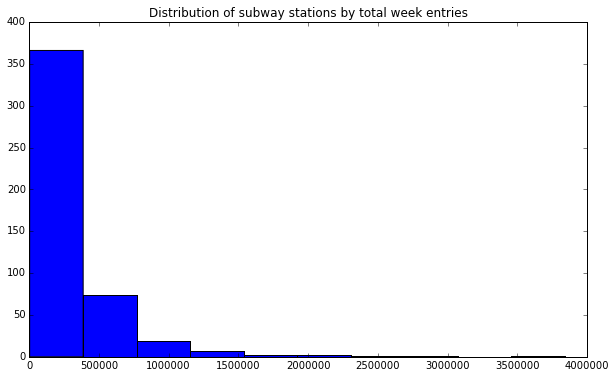

In [86]:
%matplotlib inline

allridertotals = [i for i in station_tot_dict_4wks.values()]

#print(allridertotals)
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
ax.set_title("Distribution of subway stations by total week entries")
ax.hist(allridertotals)

### Extra Stuff for the project - Figuring out average daily entry over past 4 wks

In [87]:
# Make a list of all the entry totals for the 4wk dictionary, and then plot 
# a histogram of that list.

In [74]:
def averager(dictionaryname):
    newdict = defaultdict(list)
    emptylist = []
    for key in dictionaryname:
        for rowvalues in dictionaryname[key]:
            emptylist.append(rowvalues[1])
            try:
                emptylist.extend(rowvalues[3:])
                av = sum(emptylist)/len(emptylist)
                newdict[key].append(av)
            except:
                pass
            finally:
                emptylist = []
    return dict(newdict)

thisdict = averager(finaldict)

#pprint(thisdict)
print 'Done here.'

{('1 AVE', 'L'): [15496, 16722, 22599, 24294, 25136, 25069, 25979],
 ('103 ST', '1'): [8570, 8461, 13277, 13661, 14023, 13763, 13540],
 ('103 ST', '6'): [4839, 4144, 8064, 8488, 8590, 8171, 8480],
 ('103 ST', 'BC'): [2841, 2731, 4778, 5051, 5263, 5131, 5313],
 ('103 ST-CORONA', '7'): [12860, 10805, 19804, 20041, 20469, 20346, 20757],
 ('104 ST', 'JZ'): [1325, 1114, 2320, 2382, 2474, 2399, 2379],
 ('110 ST', '6'): [9444, 8154, 14564, 15142, 15750, 15351, 15701],
 ('110 ST-CATHEDRL', '1'): [6194, 8305, 12948, 13511, 13858, 14161, 13832],
 ('110 ST-CPN', '23'): [6594, 6585, 9812, 10031, 10639, 10371, 10450],
 ('111 ST', '7'): [7948, 7141, 11182, 11072, 11377, 11228, 11446],
 ('111 ST', 'J'): [1449, 1260, 2725, 2586, 2730, 2631, 2759],
 ('116 ST', '23'): [8531, 8167, 12274, 12556, 12995, 12663, 13075],
 ('116 ST', '6'): [11978, 10096, 16495, 16555, 17553, 17035, 15101],
 ('116 ST', 'BC'): [3331, 3582, 7065, 7388, 7707, 7412, 7804],
 ('116 ST-COLUMBIA', '1'): [5656, 5533, 13456, 14524, 1484

In [75]:
#pprint(grand_master_dict)

{('1 AVE', 'L'): [636670, 159167.5],
 ('103 ST', '1'): [328875, 82218.75],
 ('103 ST', '6'): [205424, 51356.0],
 ('103 ST', 'BC'): [125595, 31398.75],
 ('103 ST-CORONA', '7'): [504593, 126148.25],
 ('104 ST', 'JZ'): [58022, 14505.5],
 ('110 ST', '6'): [380924, 95231.0],
 ('110 ST-CATHEDRL', '1'): [328767, 82191.75],
 ('110 ST-CPN', '23'): [261439, 65359.75],
 ('111 ST', '7'): [287983, 71995.75],
 ('111 ST', 'J'): [65080, 16270.0],
 ('116 ST', '23'): [324631, 81157.75],
 ('116 ST', '6'): [423649, 105912.25],
 ('116 ST', 'BC'): [179221, 44805.25],
 ('116 ST-COLUMBIA', '1'): [317315, 79328.75],
 ('121 ST', 'JZ'): [62942, 15735.5],
 ('125 ST', '1'): [199532, 49883.0],
 ('125 ST', '23'): [361667, 90416.75],
 ('125 ST', '456'): [688477, 172119.25],
 ('125 ST', 'ACBD'): [777410, 194352.5],
 ('135 ST', '23'): [401189, 100297.25],
 ('135 ST', 'BC'): [135992, 33998.0],
 ('137 ST-CITY COL', '1'): [336371, 84092.75],
 ('138 ST-3 AVE', '6'): [200624, 50156.0],
 ('138 ST-GR CONC', '45'): [86510, 216

In [76]:
complete_dict = copy.deepcopy(grand_master_dict)
for key in grand_master_dict:
    complete_dict[key].extend(thisdict[key])

pprint(complete_dict)
print 'Done here.'

{('1 AVE', 'L'): [636670,
                  159167.5,
                  15496,
                  16722,
                  22599,
                  24294,
                  25136,
                  25069,
                  25979],
 ('103 ST', '1'): [328875,
                   82218.75,
                   8570,
                   8461,
                   13277,
                   13661,
                   14023,
                   13763,
                   13540],
 ('103 ST', '6'): [205424, 51356.0, 4839, 4144, 8064, 8488, 8590, 8171, 8480],
 ('103 ST', 'BC'): [125595,
                    31398.75,
                    2841,
                    2731,
                    4778,
                    5051,
                    5263,
                    5131,
                    5313],
 ('103 ST-CORONA', '7'): [504593,
                          126148.25,
                          12860,
                          10805,
                          19804,
                          20041,
          

In [78]:
with open("Station_Complete_4wks_averages.csv", "w") as out:
    writer = csv.writer(out, delimiter = ',')
    writer.writerows([(k,v) for k,v in complete_dict.items()])
    print 'Done here.'

Done here.
